# NPZD new prototype

- start building model and fluxes

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc
 

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# to measure process time
import time as tm

In [2]:
from xsimlab.monitoring import ProgressBar

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.processes.statevars import SV, Time

from phydra.processes.forcings import ConstantForcing

from phydra.processes.fluxes import LinearOutputFlux, ForcingLinearInputFlux, MonodUptake

In [5]:
NPZD = phydra.create({
    # SV
    'N':SV,
    'P':SV,
    
    # Fluxes
    'N_loss':LinearOutputFlux,
    'P_loss':LinearOutputFlux,
    
    # Exchanges
    'Monod':MonodUptake,
    
    # Forcing
    'N_input':ForcingLinearInputFlux,
    'N0':ConstantForcing
})

In [6]:
NPZD

<xsimlab.Model (10 processes, 15 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
N
    init            [in]
P
    init            [in]
N0
    value           [in]
N_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
P_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
Monod
    resource        [in]
    consumer        [in]
    halfsat         [in] half saturation constant
N_input
    fx              [in] forcing affecting rate
    rate            [in] flowing rate
    sv              [in] state variable affected by forcing flux
Solver

In [7]:
#Model.visualize(show_inputs=True)

In [7]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,20,0.1),
            input_vars={
                'N__init':0.5,
                'P__init':0.5,
                
                'N_loss':{'sv':'N',
                          'rate':.01},
                
                'P_loss':{'sv':'P',
                          'rate':.5},
                
                'N_input':{'sv':'N',
                          'fx':'N0',
                          'rate':.5},
                
                'Monod':{'resource':'N',
                        'consumer':'P',
                        'halfsat':.5},
                
                'N0__value':2.,
            },
            output_vars={'N__value','P__value'}
            )

In [8]:
gekko_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="gekko")

In [9]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [10]:
# stepwise_setup

and solve the model like this:

In [11]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=NPZD)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
initializing state variable N
initializing state variable P
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux N_input
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.0053 seconds
here unpacking values time
here unpacking values N
here unpacking values P
finalizing: cleanup


In [12]:
# out_ds

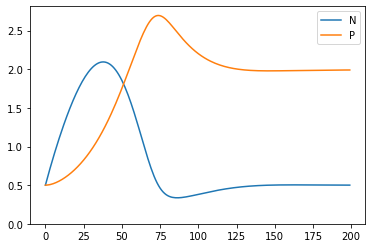

In [23]:
plt.plot(out_ds.N__value, label='N')
plt.plot(out_ds.P__value, label='P')
plt.ylim(bottom=0)
plt.legend()

In [24]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=NPZD)

             0% | initialize 

initializing model core
Initializing Model Time
creating new SV StateVariable(name='time', initial_value=0.0, value=None, lb=0)
initializing state variable N
creating new SV StateVariable(name='N', initial_value=0.5, value=None, lb=0)
initializing state variable P
creating new SV StateVariable(name='P', initial_value=0.5, value=None, lb=0)
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux N_input
assembling model
SOLVER : gekko


██████████ 100% | Simulation finished in 00:01 

Model was solved in 1.85 seconds
finalizing: cleanup


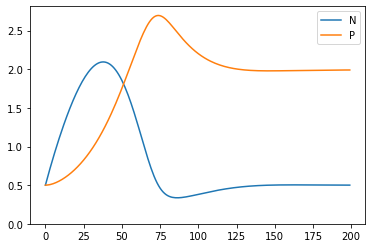

In [25]:
plt.plot(out_ds1.N__value, label='N')
plt.plot(out_ds1.P__value, label='P')
plt.ylim(bottom=0)
plt.legend()

In [26]:
with ProgressBar(frontend="console"):
    out_ds2 = stepwise_setup.xsimlab.run(model=NPZD)

██████▊     68% | run step 135/199 

initializing model core
Initializing Model Time
initializing state variable N
initializing state variable P
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux N_input
assembling model
SOLVER : stepwise


██████████ 100% | Simulation finished in 00:00 

finalizing: cleanup


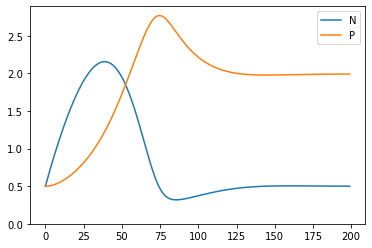

In [27]:
plt.plot(out_ds2.N__value, label='N')
plt.plot(out_ds2.P__value, label='P')
plt.ylim(bottom=0)
plt.legend()